# Credit Card Fraud Detection
## Anonymized credit card transactions labeled as fraudulent or genuine

**Context**

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

**Content**

The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

**Goal**

Identify fraudulent credit card transactions.

Given the class imbalance ratio, we will use the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  StandardScaler,OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifierCV
from sklearn.linear_model import Ridge

from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve

from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, AdaBoostClassifier,StackingClassifier,BaggingRegressor
import time
import datetime
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score,roc_auc_score
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
from xgboost import XGBClassifier


In [78]:
#importation de la dataset
dataset =pd.read_csv("creditcard.csv")

In [4]:
dataset.head(20)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [13]:
mask=dataset.Class==1
datafraud=dataset[mask]

In [14]:
# Basic stats
data_desc=dataset.describe(include='all')
print(data_desc)
dataset.shape

                 Time            V1            V2            V3            V4  \
count   284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
unique            NaN           NaN           NaN           NaN           NaN   
top               NaN           NaN           NaN           NaN           NaN   
freq              NaN           NaN           NaN           NaN           NaN   
mean     94813.859575  3.919560e-15  5.688174e-16 -8.769071e-15  2.782312e-15   
std      47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min          0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%      54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%      84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%     139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max     172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                  V5       

(284807, 32)

# Time engineering

let's divide time in differnt periods

In [79]:
periode_per_day=24
max_time=172792
inter_per_day=max_time/2/periode_per_day
inter_per_day=np.round(inter_per_day,0)
inter_per_day

3600.0

In [80]:
3600*24

86400

In [81]:
def get_in(x,per):
    if x>=per[0] and x<per[1]:
        return True
    else:
        return False

In [82]:
per=[0,15]
x=6
get_in(x,per)

True

In [83]:
def get_period(x):
    temp1=max_time/2
    deb=0
    if x< temp1:
        for i in range(periode_per_day):
            per=[deb,deb+inter_per_day]
            if get_in(x,per):
                return ('per'+str(i))
            else:
                deb=deb+inter_per_day
        
    else:
        deb=deb+inter_per_day*periode_per_day
        for i in range(periode_per_day):
            per=[deb,deb+inter_per_day]
            if get_in(x,per):
                return ('per'+str(i))
            else:
                deb=deb+inter_per_day
    

In [84]:
get_period(170000)

'per23'

In [85]:
dataset['time2']=dataset['Time']

In [86]:
dataset['time2']=dataset['time2'].apply(lambda x:str(get_period(x) ) )

In [129]:
dataset.sample(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,time2
27206,34440.0,-2.604002,-0.892010,0.726497,0.615739,1.162403,-1.393118,-0.174094,0.459805,-0.408690,...,-0.384888,1.854719,-0.002268,0.244255,0.167412,0.274389,-0.179089,8.99,0,per9
136223,81605.0,1.260964,0.238480,-0.160822,0.941937,0.235053,-0.109771,0.161705,-0.018062,-0.018144,...,-0.005414,-0.258425,-0.491866,0.911423,-0.241012,0.003147,-0.006090,2.37,0,per22
137219,82069.0,-0.551364,1.015605,1.628031,-0.358399,0.184723,-1.052968,0.813188,-0.088804,-0.512041,...,-0.870564,-0.147763,0.323762,0.283841,0.018915,-0.075906,-0.016066,1.98,0,per22
61083,49652.0,-0.392784,1.015525,1.380316,0.002703,-0.110317,-0.803702,0.531996,0.124941,-0.498177,...,-0.630770,0.005123,0.453890,-0.256993,0.045634,0.235708,0.087522,0.89,0,per13
68335,52943.0,-0.913753,-4.305533,-0.551163,-0.592244,-2.258949,0.386143,0.434521,0.123100,1.961417,...,-0.444254,-0.973327,-0.261625,-0.188628,-0.102891,-0.166708,0.194354,1100.00,0,per14
40768,40392.0,0.180367,-2.320091,-2.393357,-0.099322,1.438798,3.376369,0.420557,0.468550,-1.594167,...,-1.169199,-0.669946,0.998749,0.653483,-0.332582,-0.104583,0.122331,653.56,0,per11
162406,115087.0,2.393675,-1.101347,-1.886163,-1.589444,-0.487730,-1.038272,-0.397735,-0.496884,-1.618614,...,-0.021245,0.012443,-0.632991,0.297393,-0.002429,-0.026639,-0.075047,14.95,0,per7
210115,137847.0,0.050794,0.858237,0.229352,-0.618472,0.474722,-1.037323,1.018586,-0.200411,-0.039319,...,-0.596417,0.056365,-0.116784,-0.467704,0.147275,0.246383,0.096147,5.38,0,per14
151756,96192.0,2.030092,-0.321602,-1.290775,0.191196,0.220023,-0.022824,-0.295418,-0.047261,2.341092,...,0.263754,0.017951,0.253579,0.188381,0.132263,-0.070619,-0.076916,14.50,0,per2
21269,31566.0,1.446566,-0.268650,-0.190397,-0.657928,-0.610225,-1.398030,-0.005220,-0.428492,-1.196663,...,0.507481,-0.169800,0.430734,0.802808,-0.085606,-0.027150,0.002715,15.00,0,per8


In [176]:
 pd.set_option('display.max_rows', None)
dataset[dataset.Class==1]['Amount'].value_counts()

1.00       113
0.00        27
99.99       27
0.76        17
0.77        10
0.01         5
2.00         4
3.79         4
1.10         3
2.28         3
12.31        3
1.18         3
0.68         3
723.21       2
188.52       2
94.82        2
0.83         2
88.23        2
7.59         2
1.63         2
104.03       2
19.02        2
39.45        2
1.59         2
45.51        2
512.25       2
105.89       2
316.06       2
30.31        2
111.70       2
18.96        2
8.00         2
44.90        2
78.00        2
101.50       2
1.52         2
252.92       2
227.30       1
261.87       1
98.01        1
4.90         1
119.74       1
529.00       1
1354.25      1
8.30         1
77.89        1
2125.87      1
42.53        1
112.33       1
0.69         1
17.39        1
519.90       1
105.99       1
3.14         1
125.30       1
1504.93      1
30.30        1
130.44       1
106.55       1
451.27       1
104.81       1
11.39        1
38.76        1
320.01       1
634.30       1
118.30       1
5.91      

***we have 492 frauds out of 284,807 transactions (0.172%)***

***27 frauds have an amount of 27***

# MODEL

In [303]:
col=dataset.columns
col

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'time2'],
      dtype='object')

In [304]:
col=col.drop(['Class'])
col

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'time2'],
      dtype='object')

In [305]:
features_list = col
target_variable = 'Class'

In [306]:
len(features_list)

31

In [307]:
X = dataset.loc[:, features_list]
Y = dataset.loc[:, target_variable]

print('Variables explicatives : ', X.columns)
print()

Variables explicatives :  Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'time2'],
      dtype='object')



In [308]:
X.shape

(284807, 31)

In [309]:
idx = 0
numeric_features = []
numeric_indices = []
categorical_features = []
categorical_indices = []
for i,t in X.dtypes.iteritems():
  if ('float' in str(t)) or ('int' in str(t)) :
    numeric_features.append(i)
    numeric_indices.append(idx)
  else :
    categorical_features.append(i)
    categorical_indices.append(idx)

  idx = idx + 1

print('Found numeric features ', numeric_features,' at positions ', numeric_indices)
print('Found categorical features ', categorical_features,' at positions ', categorical_indices)


Found numeric features  ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']  at positions  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Found categorical features  ['time2']  at positions  [30]


In [310]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42,stratify=Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [311]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values
print("...Done")

print(X_train[0:5,:])
print(X_test[0:2,:])
print()
print(Y_train[0:5])
print(Y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done
[[161919.0 1.9467466672816798 -0.752525821492348 -1.3551295328913102
  -0.661629913230695 1.50282190770174 4.02493282673061
  -1.4796614838390902 1.1398802168957198 1.4068187137481298
  -0.15740291266068202 -0.11372919032959901 0.510277474082635
  0.0612577807353701 -0.0665551394957695 1.3287018205003602
  0.352513902823239 -0.76566982664618 0.14193753685938199
  -0.451364651514137 -0.134434695487417 0.0761965101986691
  0.297536541043559 0.30791456949789503 0.690980284177926
  -0.350316231256655 -0.388907264903717 0.0776408382302655
  -0.0322477642202041 7.32 'per20']
 [124477.0 2.03514918623719 -0.0488803143003422 -3.0586934537638997
  0.24794503371213297 2.94348685227235 3.2986973115731204
  -0.0021924639358902698 0.674781823977897 0.0458257088345251
  0.28486427695311 -0.254903244909153 0.325559776048587
  -0.405326546442527 0.7210684077145 -0.14844514500485 -0.754029381288908
  -0.270842357681763 -0.6956978417796721 -0.274411134

In [312]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")

if categorical_indices==[]:
    # Normalization
    print("just scaling")
    featureencoder = StandardScaler()
    
elif numeric_indices==[]:
    # OHE / dummyfication
    print("encoding")
    featureencoder = OneHotEncoder(drop='first') 
    
else:

    # Normalization
    numeric_transformer = StandardScaler()

    # OHE / dummyfication
    categorical_transformer = OneHotEncoder(drop='first')
    featureencoder = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_indices),    
            ('num', numeric_transformer, numeric_indices)
            ]    )

X_train = featureencoder.fit_transform(X_train)

print("...Done")
print(X_train[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.41158751e+00  9.93379083e-01 -4.56036586e-01 -8.94051557e-01
  -4.67283725e-01  1.08921729e+00  3.02438347e+00 -1.19485202e+00
   9.57057418e-01  1.28137638e+00 -1.44546401e-01 -1.10814578e-01
   5.09338566e-01  6.21173504e-02 -6.95576832e-02  1.45109663e+00
   4.04446404e-01 -9.07403516e-01  1.69133453e-01 -5.55365736e-01
  -1.73112388e-01  1.03171150e-01  4.09563109e-01  4.90684977e-01
   1.14196982e+00 -6.70831980e-01 -8.07226946e-01  1.91911522e-01
  -9.91057622e-02 -3.22493763e-01]
 [ 0.00000000e+00  0.00000000

In [313]:
import tensorflow as tf
from tensorflow import keras

In [319]:
full_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
full_ds


<TensorSliceDataset shapes: ((54,), ()), types: (tf.float64, tf.int64)>

In [320]:
input_shape=X_train.shape[1]
input_shape

54

In [321]:
BATCH_SIZE=5000
full_ds =full_ds.batch(BATCH_SIZE)
full_ds

<BatchDataset shapes: ((None, 54), (None,)), types: (tf.float64, tf.int64)>

In [322]:
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(32, activation="relu", input_shape=[input_shape]),
                             tf.keras.layers.Dense(16, activation="relu"),
                             tf.keras.layers.Dense(8, activation="relu"),
                             tf.keras.layers.Dense(1, activation="sigmoid")
])

In [323]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

# Création d'un compileur
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              loss= tf.keras.losses.binary_crossentropy,
              metrics =METRICS)

In [329]:
model.fit(full_ds, epochs=100)

Train for 46 steps
Epoch 1/100
46/46 [==============================] - 1s 18ms/step - loss: 0.0041 - tp: 282.0000 - fp: 32.0000 - tn: 227419.0000 - fn: 112.0000 - accuracy: 0.9994 - precision: 0.8981 - recall: 0.7157 - auc: 0.9289
Epoch 2/100
46/46 [==============================] - 1s 20ms/step - loss: 0.0040 - tp: 286.0000 - fp: 33.0000 - tn: 227418.0000 - fn: 108.0000 - accuracy: 0.9994 - precision: 0.8966 - recall: 0.7259 - auc: 0.9307
Epoch 3/100
46/46 [==============================] - 1s 19ms/step - loss: 0.0038 - tp: 289.0000 - fp: 33.0000 - tn: 227418.0000 - fn: 105.0000 - accuracy: 0.9994 - precision: 0.8975 - recall: 0.7335 - auc: 0.9323
Epoch 4/100
46/46 [==============================] - 1s 18ms/step - loss: 0.0037 - tp: 292.0000 - fp: 33.0000 - tn: 227418.0000 - fn: 102.0000 - accuracy: 0.9994 - precision: 0.8985 - recall: 0.7411 - auc: 0.9325
Epoch 5/100
46/46 [==============================] - 1s 18ms/step - loss: 0.0036 - tp: 293.0000 - fp: 33.0000 - tn: 227418.0000 -

46/46 [==============================] - 1s 18ms/step - loss: 0.0021 - tp: 308.0000 - fp: 20.0000 - tn: 227431.0000 - fn: 86.0000 - accuracy: 0.9995 - precision: 0.9390 - recall: 0.7817 - auc: 0.9589
Epoch 39/100
46/46 [==============================] - 1s 18ms/step - loss: 0.0021 - tp: 309.0000 - fp: 20.0000 - tn: 227431.0000 - fn: 85.0000 - accuracy: 0.9995 - precision: 0.9392 - recall: 0.7843 - auc: 0.9589
Epoch 40/100
46/46 [==============================] - 1s 18ms/step - loss: 0.0020 - tp: 310.0000 - fp: 20.0000 - tn: 227431.0000 - fn: 84.0000 - accuracy: 0.9995 - precision: 0.9394 - recall: 0.7868 - auc: 0.9602
Epoch 41/100
46/46 [==============================] - 1s 18ms/step - loss: 0.0020 - tp: 309.0000 - fp: 19.0000 - tn: 227432.0000 - fn: 85.0000 - accuracy: 0.9995 - precision: 0.9421 - recall: 0.7843 - auc: 0.9615
Epoch 42/100
46/46 [==============================] - 1s 18ms/step - loss: 0.0020 - tp: 309.0000 - fp: 19.0000 - tn: 227432.0000 - fn: 85.0000 - accuracy: 0.9995

46/46 [==============================] - 1s 19ms/step - loss: 0.0012 - tp: 343.0000 - fp: 9.0000 - tn: 227442.0000 - fn: 51.0000 - accuracy: 0.9997 - precision: 0.9744 - recall: 0.8706 - auc: 0.9846
Epoch 76/100
46/46 [==============================] - 1s 18ms/step - loss: 0.0012 - tp: 344.0000 - fp: 9.0000 - tn: 227442.0000 - fn: 50.0000 - accuracy: 0.9997 - precision: 0.9745 - recall: 0.8731 - auc: 0.9846
Epoch 77/100
46/46 [==============================] - 1s 18ms/step - loss: 0.0012 - tp: 344.0000 - fp: 8.0000 - tn: 227443.0000 - fn: 50.0000 - accuracy: 0.9997 - precision: 0.9773 - recall: 0.8731 - auc: 0.9846
Epoch 78/100
46/46 [==============================] - 1s 18ms/step - loss: 0.0012 - tp: 345.0000 - fp: 8.0000 - tn: 227443.0000 - fn: 49.0000 - accuracy: 0.9997 - precision: 0.9773 - recall: 0.8756 - auc: 0.9846
Epoch 79/100
46/46 [==============================] - 1s 18ms/step - loss: 0.0011 - tp: 344.0000 - fp: 9.0000 - tn: 227442.0000 - fn: 50.0000 - accuracy: 0.9997 - pr

In [325]:
print("Encoding categorical features and standardizing numerical features...")

X_test = featureencoder.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          1.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   1.3871815  -0.34471083  0.85416023 -0.73269126 -0.93818762  1.00670883
  -0.98201123  1.52273861 -0.51515709  0.28336517  0.59944458 -0.84085508
  -0.23349522 -0.20050673  0.27869502 -0.05167318 -0.84682349 -0.7178194
  -0.4680386  -0.20064633  0.51286793  0.10846086  1.11574075 -0.3576211
   1.16992023 -0.25934891  0.09332341  1.31850867  0.89058207 -0.25995439]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          1.          0.          0.          0.          0.
  -1.58013819 -1.44498471

In [326]:
ds_valid = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [330]:
train_predictions_baseline = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE)

In [331]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.0032043995977047183
tp :  81.0
fp :  15.0
tn :  56849.0
fn :  17.0
accuracy :  0.9994382
precision :  0.84375
recall :  0.82653064
auc :  0.94355744

Legitimate Transactions Detected (True Negatives):  56849
Legitimate Transactions Incorrectly Detected (False Positives):  15
Fraudulent Transactions Missed (False Negatives):  17
Fraudulent Transactions Detected (True Positives):  81
Total Fraudulent Transactions:  98


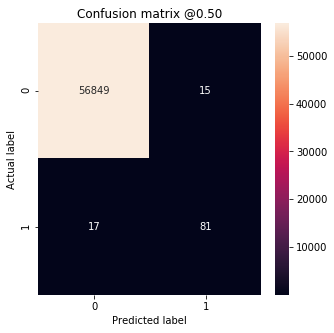

In [332]:
baseline_results = model.evaluate(X_test,Y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()


plot_cm(Y_test, test_predictions_baseline)

# Oversampling
## Oversample the minority class

In [194]:
X_train_pd=pd.DataFrame(X_train)
Y_train_pd=pd.DataFrame(Y_train)


In [195]:
bool_train_labels = Y_train != 0

In [198]:
len(X_train_pd)

227845

In [197]:
pos_features = X_train_pd[bool_train_labels]
neg_features = X_train_pd[~bool_train_labels]

pos_labels = Y_train_pd[bool_train_labels]
neg_labels =Y_train_pd[~bool_train_labels]

In [245]:
print("nb 0:",len(neg_features))
print("nb 1:",len(pos_features))

nb 0: 227451
nb 1: 394


In [251]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

print("choices shape",len(choices))

choices shape 227451


In [248]:
choices

array([ 75,  73,  45, ...,  63, 118, 205])

In [260]:
temp1f= pos_features.reset_index()
temp2f=temp1f.drop('index', axis=1)
temp2f.iloc[choices,:]





,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.911114,-0.065896,-0.826271,0.114983,-0.991333,0.713663,-0.769968,0.029735,0.445777,-0.347701
279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.767273,0.388404,-1.063490,-0.422765,-1.441881,1.804239,-0.454853,2.159775,1.438437,-0.347701
112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.064825,0.236380,-0.375906,-0.050365,-0.670535,0.303941,-0.216872,0.182415,-0.127620,-0.347701
151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-2.357689,0.139521,0.428977,-6.581340,0.057682,-2.173639,0.564677,4.547364,-5.494968,2.521532
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.450028,7.569015,-2.216480,1.538484,0.270923,0.092446,0.967010,0.688058,4.501870,0.070651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.116992,2.407391,-2.331813,-1.666711,0.237335,3.093103,-0.460021,3.658143,1.339613,0.047119
195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.041956,2.376224,-1.864942,-1.216121,0.193790,2.491487,-0.466764,4.003435,1.481810,0.047119
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.505065,0.283632,-0.705561,-0.930583,-0.362730,2.830603,1.018940,1.281542,1.230734,-0.347701
344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.425233,0.407367,-0.804132,-0.299237,-0.543478,1.406245,0.120251,1.366186,0.974736,-0.344710


In [262]:
temp1l=pos_labels.reset_index()
temp2l=temp1l.drop('index', axis=1)
temp2l.iloc[choices,:]



,0
387,1
279,1
112,1
151,1
19,1
...,...
36,1
195,1
1,1
344,1


In [263]:
res_pos_features = temp2f.iloc[choices,:]
res_pos_labels = temp2l.iloc[choices,:]

In [265]:
res_pos_features.shape


(227451, 54)

In [266]:
res_pos_labels.shape

(227451, 1)

In [267]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(454902, 54)

In [272]:
full_ds_resampled = tf.data.Dataset.from_tensor_slices((resampled_features, resampled_labels))
full_ds_resampled 

<TensorSliceDataset shapes: ((54,), (1,)), types: (tf.float64, tf.int64)>

In [273]:
BATCH_SIZE=50
full_ds_resampled =full_ds_resampled.batch(BATCH_SIZE)
full_ds_resampled

<BatchDataset shapes: ((None, 54), (None, 1)), types: (tf.float64, tf.int64)>

In [275]:
model2 = tf.keras.Sequential([
                             tf.keras.layers.Dense(32, activation="relu", input_shape=[input_shape]),
                             tf.keras.layers.Dense(16, activation="relu"),
                             tf.keras.layers.Dense(8, activation="relu"),
                             tf.keras.layers.Dense(1, activation="sigmoid")
])

In [278]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

# Création d'un compileur
model2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              loss= tf.keras.losses.binary_crossentropy,
              metrics =METRICS)

In [289]:
model2.fit(full_ds_resampled, epochs=10)

Train for 9099 steps
Epoch 1/10
9099/9099 [==============================] - 14s 2ms/step - loss: 2.2475e-04 - tp: 227448.0000 - fp: 5.0000 - tn: 227446.0000 - fn: 3.0000 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 2/10
9099/9099 [==============================] - 14s 2ms/step - loss: 9.0037e-05 - tp: 227446.0000 - fp: 4.0000 - tn: 227447.0000 - fn: 5.0000 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 3/10
9099/9099 [==============================] - 14s 2ms/step - loss: 9.9825e-05 - tp: 227447.0000 - fp: 4.0000 - tn: 227447.0000 - fn: 4.0000 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 4/10
9099/9099 [==============================] - 15s 2ms/step - loss: 8.8754e-05 - tp: 227448.0000 - fp: 6.0000 - tn: 227445.0000 - fn: 3.0000 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 5/10
9099/9099 [==============================] - 15s 2ms/step - loss: 1.2092e-04 - tp: 22744

In [290]:
train_predictions_resampled = model2.predict(resampled_features, batch_size=BATCH_SIZE)
test_predictions_resampled  = model2.predict(X_test, batch_size=BATCH_SIZE)

loss :  0.07980899731700507
tp :  73.0
fp :  19.0
tn :  56845.0
fn :  25.0
accuracy :  0.9992276
precision :  0.79347825
recall :  0.74489796
auc :  0.8824857

Legitimate Transactions Detected (True Negatives):  56845
Legitimate Transactions Incorrectly Detected (False Positives):  19
Fraudulent Transactions Missed (False Negatives):  25
Fraudulent Transactions Detected (True Positives):  73
Total Fraudulent Transactions:  98


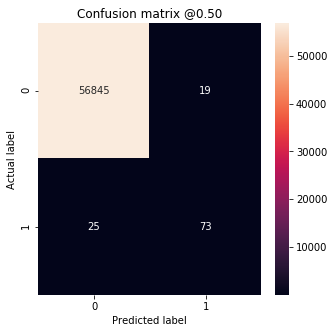

In [291]:
sampled_results = model2.evaluate(X_test,Y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model2.metrics_names, sampled_results):
  print(name, ': ', value)
print()


plot_cm(Y_test, test_predictions_resampled )

# Class weights
## Calculate class weights
The goal is to identify fradulent transactions, but we don't have very many of those positive samples to work with, so we would want to have the classifier heavily weight the few examples that are available. 

We can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [341]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.

total=len(neg_features)+len(pos_features)

weight_for_0 = (1 /len(neg_features))*(total)/2.0 
weight_for_1 = (1 /len(pos_features))*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.14


In [613]:
# Balance des classes
class_weight = {
    0:0.5,
    1:495,
   }

In [614]:
class_weight

{0: 0.5, 1: 495}

In [615]:
model3 = tf.keras.Sequential([
                             tf.keras.layers.Dense(32, activation="relu", input_shape=[input_shape]),
                             tf.keras.layers.Dense(16, activation="relu"),
                             tf.keras.layers.Dense(8, activation="relu"),
                             tf.keras.layers.Dense(1, activation="sigmoid")
])

In [616]:
model3.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              loss= tf.keras.losses.binary_crossentropy,
              metrics =METRICS)

In [617]:
model3.fit(full_ds,  epochs=110, 
     
                    class_weight=class_weight)

Train for 46 steps
Epoch 1/110
46/46 [==============================] - 2s 46ms/step - loss: 1.1227 - tp: 239.0000 - fp: 58383.0000 - tn: 169068.0000 - fn: 155.0000 - accuracy: 0.7431 - precision: 0.0041 - recall: 0.6066 - auc: 0.6650
Epoch 2/110
46/46 [==============================] - 1s 18ms/step - loss: 0.4430 - tp: 366.0000 - fp: 59413.0000 - tn: 168038.0000 - fn: 28.0000 - accuracy: 0.7391 - precision: 0.0061 - recall: 0.9289 - auc: 0.9460
Epoch 3/110
46/46 [==============================] - 1s 19ms/step - loss: 0.3448 - tp: 361.0000 - fp: 17603.0000 - tn: 209848.0000 - fn: 33.0000 - accuracy: 0.9226 - precision: 0.0201 - recall: 0.9162 - auc: 0.9580
Epoch 4/110
46/46 [==============================] - 1s 19ms/step - loss: 0.2783 - tp: 363.0000 - fp: 9110.0000 - tn: 218341.0000 - fn: 31.0000 - accuracy: 0.9599 - precision: 0.0383 - recall: 0.9213 - auc: 0.9716
Epoch 5/110
46/46 [==============================] - 1s 19ms/step - loss: 0.2323 - tp: 368.0000 - fp: 7868.0000 - tn: 219

46/46 [==============================] - 1s 17ms/step - loss: 0.0237 - tp: 394.0000 - fp: 2264.0000 - tn: 225187.0000 - fn: 0.0000e+00 - accuracy: 0.9901 - precision: 0.1482 - recall: 1.0000 - auc: 0.9995
Epoch 39/110
46/46 [==============================] - 1s 19ms/step - loss: 0.0230 - tp: 394.0000 - fp: 2200.0000 - tn: 225251.0000 - fn: 0.0000e+00 - accuracy: 0.9903 - precision: 0.1519 - recall: 1.0000 - auc: 0.9995
Epoch 40/110
46/46 [==============================] - 1s 18ms/step - loss: 0.0220 - tp: 394.0000 - fp: 2081.0000 - tn: 225370.0000 - fn: 0.0000e+00 - accuracy: 0.9909 - precision: 0.1592 - recall: 1.0000 - auc: 0.9995
Epoch 41/110
46/46 [==============================] - 1s 17ms/step - loss: 0.0211 - tp: 394.0000 - fp: 2019.0000 - tn: 225432.0000 - fn: 0.0000e+00 - accuracy: 0.9911 - precision: 0.1633 - recall: 1.0000 - auc: 0.9995
Epoch 42/110
46/46 [==============================] - 1s 17ms/step - loss: 0.0204 - tp: 394.0000 - fp: 1966.0000 - tn: 225485.0000 - fn: 0.00

46/46 [==============================] - 1s 18ms/step - loss: 0.0078 - tp: 394.0000 - fp: 725.0000 - tn: 226726.0000 - fn: 0.0000e+00 - accuracy: 0.9968 - precision: 0.3521 - recall: 1.0000 - auc: 0.9997 0s - loss: 0.0076 - tp: 317.0000 - fp: 572.0000 - tn: 184111.0000 - fn: 0.0000e+00 - accuracy: 0.9969 - precision: 0.3566 - recall: 1.0000 - auc: 0.
Epoch 73/110
46/46 [==============================] - 1s 19ms/step - loss: 0.0076 - tp: 394.0000 - fp: 725.0000 - tn: 226726.0000 - fn: 0.0000e+00 - accuracy: 0.9968 - precision: 0.3521 - recall: 1.0000 - auc: 0.9998
Epoch 74/110
46/46 [==============================] - 1s 19ms/step - loss: 0.0074 - tp: 394.0000 - fp: 688.0000 - tn: 226763.0000 - fn: 0.0000e+00 - accuracy: 0.9970 - precision: 0.3641 - recall: 1.0000 - auc: 0.9998
Epoch 75/110
46/46 [==============================] - 1s 20ms/step - loss: 0.0071 - tp: 394.0000 - fp: 674.0000 - tn: 226777.0000 - fn: 0.0000e+00 - accuracy: 0.9970 - precision: 0.3689 - recall: 1.0000 - auc: 0.9

46/46 [==============================] - 1s 20ms/step - loss: 0.0030 - tp: 394.0000 - fp: 240.0000 - tn: 227211.0000 - fn: 0.0000e+00 - accuracy: 0.9989 - precision: 0.6215 - recall: 1.0000 - auc: 0.9999
Epoch 109/110
46/46 [==============================] - 1s 18ms/step - loss: 0.0030 - tp: 394.0000 - fp: 253.0000 - tn: 227198.0000 - fn: 0.0000e+00 - accuracy: 0.9989 - precision: 0.6090 - recall: 1.0000 - auc: 0.9999
Epoch 110/110
46/46 [==============================] - 1s 19ms/step - loss: 0.0029 - tp: 394.0000 - fp: 244.0000 - tn: 227207.0000 - fn: 0.0000e+00 - accuracy: 0.9989 - precision: 0.6176 - recall: 1.0000 - auc: 0.9999


In [618]:
train_predictions_w = model3.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_w = model3.predict(X_test, batch_size=BATCH_SIZE)

loss :  0.011168410957483763
tp :  86.0
fp :  103.0
tn :  56761.0
fn :  12.0
accuracy :  0.99798113
precision :  0.45502645
recall :  0.877551
auc :  0.9533219

Legitimate Transactions Detected (True Negatives):  56761
Legitimate Transactions Incorrectly Detected (False Positives):  103
Fraudulent Transactions Missed (False Negatives):  12
Fraudulent Transactions Detected (True Positives):  86
Total Fraudulent Transactions:  98


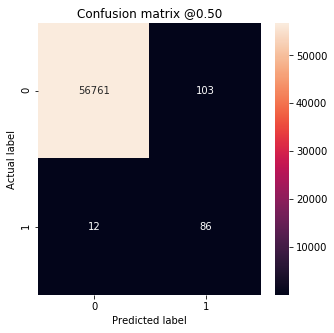

In [619]:
sampled_results = model3.evaluate(X_test,Y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model3.metrics_names, sampled_results):
  print(name, ': ', value)
print()


plot_cm(Y_test,test_predictions_w  )